In [3]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, GRU,SimpleRNN
from keras.initializers import glorot_uniform, Constant, Identity
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, Adadelta
from keras import backend as K
import numpy as np  
import matplotlib.pyplot as plt

C:\Users\User-PC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def load_dataset(csv_path, label_col='y'):
    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)
    return inputs, labels

In [5]:
def traiding_model(prediction, actual):
    status = 'buy'
    profit = np.zeros(len(prediction))
    current_profit = 0
    for i in range(len(prediction)-1):
        if status == 'buy' and prediction[i+1]>prediction[i]:
            buy_index = i
            status = 'sell'
        if status == 'sell' and prediction[i+1]<prediction[i]:
            sell_index = i
            status = 'buy'
            current_profit = current_profit + actual[sell_index]- actual[buy_index]
        profit[i]=current_profit
    if status == 'sell': #sell at the end
        profit[-1] = current_profit + actual[-1]- actual[buy_index]
    else :
        profit[-1] = current_profit
    return profit

In [31]:
#load raw data
d = 1 #choose what data to work on 1=IBM, 2=DOW JONES, 3 = Exxon Mobil
save = False #save results to file ?
if d == 1:
    _,training_data = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\weighted_linear_regression\IBM_train_1962.csv')
    _,test_data_1 = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\weighted_linear_regression\IBM_dev.csv')
    _,test_data_2 = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\weighted_linear_regression\IBM_test.csv')
elif d==2:
    _,training_data = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\weighted_linear_regression\dow_train_all.csv')
    _,test_data_1 = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\weighted_linear_regression\dow_dev.csv')
    _,test_data_2 = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\weighted_linear_regression\dow_test.csv')
elif d == 3:
    _,training_data = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\NN\XOM_train_1962.csv')
    _,test_data_1 = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\NN\XOM_dev.csv')
    _,test_data_2 = load_dataset(r'C:\Users\User-PC\Dropbox\CS229_machine_learning\Project\NN\XOM_test.csv')


In [32]:
#form X_train and Y_train 
Tx = 15
Ty = 1
chunk_size_x = 7
chunk_size_y = 50
ratios=training_data[1:]/training_data[:-1]
if d == 1:
    batch_size =202
elif d==2:
    batch_size = 176
elif d == 3:
    batch_size = 101
m = ((len(ratios)-chunk_size_x*Tx)//(chunk_size_x) - chunk_size_y//chunk_size_x) //batch_size*batch_size 
X_train = np.zeros((m,Tx,chunk_size_x))
Y_train = np.zeros((m,chunk_size_y))
for i in range(m):
    X_train[i,:,:] = np.reshape(ratios[i*chunk_size_x:(i+Tx)*chunk_size_x],(Tx,chunk_size_x))
    Y_train[i,:] = np.reshape(ratios[(i+Tx)*chunk_size_x:(i+Tx)*chunk_size_x+Ty*chunk_size_y],(Ty,chunk_size_y)) 
print('test_data_1',test_data_1.shape)
print('test_data_2',test_data_2.shape)
print('training_data',training_data.shape)
print('X_train shape: ', X_train.shape)
print('Y_train shape: ',Y_train.shape)

test_data_1 (252,)
test_data_2 (251,)
training_data (14295,)
X_train shape:  (2020, 15, 7)
Y_train shape:  (2020, 50)


In [24]:
#NN model
def model_2(Tx,chunk_size_x,chunk_size_y):
    model = Sequential()
    model.add(GRU(2*chunk_size_x, input_shape=(Tx, chunk_size_x), return_sequences=False))
    #model.add(Dropout(0.1))
    #model.add(LSTM(100, return_sequences=False))
    #model.add(Dropout(0.3))
    #model.add(Dense(chunk_size_y, activation='sigmoid'))
    model.add(Dense(chunk_size_y, activation='sigmoid',))
    model.add(Dense(chunk_size_y, activation='linear',kernel_initializer='identity',bias_initializer=Constant(value=0.5),trainable=False))
    return model

In [25]:
model = model_2(Tx, chunk_size_x, chunk_size_y)
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.05)
opt=SGD(lr=1, momentum=0.01, decay=0.01, nesterov=False)
#opt=Adadelta(lr=1, rho=0.95, epsilon=None, decay=0.05)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 14)                924       
_________________________________________________________________
dense_9 (Dense)              (None, 50)                750       
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
Total params: 4,224
Trainable params: 1,674
Non-trainable params: 2,550
_________________________________________________________________


In [26]:
#train
n_epochs=20
history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/20
1919/1919 [==============================] - 3s 2ms/step - loss: 0.0022 - mean_absolute_percentage_error: 3.7193
Epoch 2/20
1919/1919 [==============================] - 1s 269us/step - loss: 0.0012 - mean_absolute_percentage_error: 2.7056
Epoch 3/20
1919/1919 [==============================] - 1s 294us/step - loss: 8.3445e-04 - mean_absolute_percentage_error: 2.2147
Epoch 4/20
1919/1919 [==============================] - 1s 277us/step - loss: 6.4137e-04 - mean_absolute_percentage_error: 1.9355
Epoch 5/20
1919/1919 [==============================] - 1s 261us/step - loss: 5.3049e-04 - mean_absolute_percentage_error: 1.7566
Epoch 6/20
1919/1919 [==============================] - 0s 220us/step - loss: 4.5976e-04 - mean_absolute_percentage_error: 1.63260s - loss: 4.4832e-04 - mean_absolute_percentage_error: 1.62
Epoch 7/20
1919/1919 [==============================] - 0s 179us/step - loss: 4.1119e-04 - mean_absolute_percentage_error: 1.5412
Epoch 8/20
1919/1919 [==================

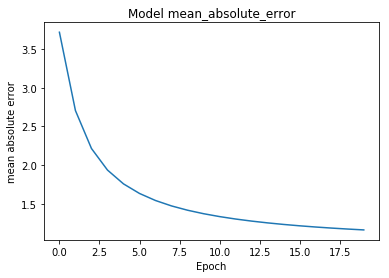

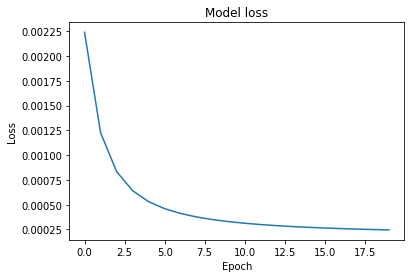

In [28]:
# Plot training & validation mape values
plt.plot(history.history['mean_absolute_percentage_error'])
plt.title('Model mean_absolute_error')
plt.ylabel('mean absolute error')
plt.xlabel('Epoch')
if save:
    if d == 1:
        plt.savefig('IBM_mape.png',bbox_inches='tight')
    elif d==2:
        plt.savefig('DOW_mape.png',bbox_inches='tight')
    elif d == 3:
        plt.savefig('XOM_mape.png',bbox_inches='tight')
plt.show()   

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
if save:
    if d == 1:
        plt.savefig('IBM_loss.png',bbox_inches='tight')
    elif d==2:
        plt.savefig('DOW_loss.png',bbox_inches='tight')
    elif d == 3:
        plt.savefig('XOM_loss.png',bbox_inches='tight')
plt.show()

In [33]:
#predictions on test_data_1
batch_size_plotting = 1
test_data =test_data_1
anchor = test_data[Tx*chunk_size_x-1]

#transform to ratios
test_ratios = test_data[1:]/test_data[:-1]
test_ratios_1=test_ratios.copy()
n_chunks = (len(test_ratios)-Tx*chunk_size_x)//chunk_size_y
if save :
    x=np.zeros((batch_size_plotting,Tx,chunk_size_x))
    y_predict_ratios=np.zeros((n_chunks*chunk_size_y))
    x[0,:,:] = np.reshape(test_ratios[:Tx*chunk_size_x],(1,Tx,chunk_size_x))

#a0 = np.random.randn(1, n_a)
#c0 = np.random.randn(1, n_a)

    for i in range(n_chunks):
        #pred = model.predict([x, a0_t, c0_t])
        pred = model.predict(x)
        y_predict_ratios[(i*chunk_size_y):((i+1)*chunk_size_y)]=pred[0,:].flatten()
        x_inter = x[0,:,:].flatten()
        x_inter[:-chunk_size_y]=x_inter[chunk_size_y:]
        x_inter[-chunk_size_y:]=pred[0,:].flatten()
        x[0,:,:]=x_inter.reshape((Tx,chunk_size_x))
    
if not save:
    if d == 1:
        y_predict_ratios=np.loadtxt('IBM_ratios_2016')
    elif d==2:
        y_predict_ratios=np.loadtxt('DOW_ratios_2016')
    elif d == 3:
        y_predict_ratios=np.loadtxt('XOM_ratios_2016')
    

ratios mape 2016 =  1.40007895186567
ratios mse 2016 =  0.00033186063171574765


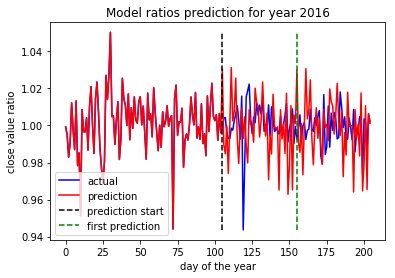

close mape 2016 =  5.646846665350049
close mse 2016 =  98.21705176667385


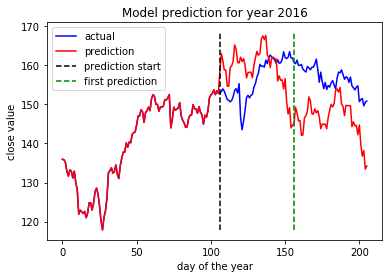

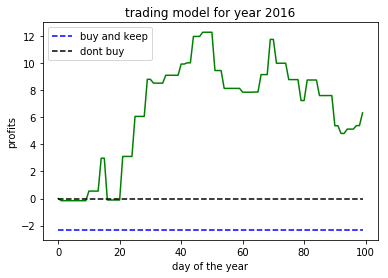

In [34]:
#plot ratios
plt.plot(range(Tx*chunk_size_x+n_chunks*chunk_size_y),test_ratios[:Tx*chunk_size_x+n_chunks*chunk_size_y],'b-',label='actual')
plt.plot(range(Tx*chunk_size_x+n_chunks*chunk_size_y),np.concatenate((test_ratios[:Tx*chunk_size_x],y_predict_ratios),axis=None),'r-',label='prediction')
plt.plot(np.array([Tx*chunk_size_x, Tx*chunk_size_x]),np.array([min(np.array([min(test_ratios),min(y_predict_ratios)])), max(np.array([max(test_ratios),max(y_predict_ratios)]))]),'--',color='black',label='prediction start')
plt.plot(np.array([Tx*chunk_size_x+chunk_size_y, Tx*chunk_size_x+chunk_size_y]),np.array([min(np.array([min(test_ratios),min(y_predict_ratios)])), max(np.array([max(test_ratios),max(y_predict_ratios)]))]),'--',color='green',label='first prediction')
plt.title('Model ratios prediction for year 2016')
plt.ylabel('close value ratio')
plt.xlabel('day of the year')
plt.legend()
mse = np.mean((y_predict_ratios - test_ratios[Tx*chunk_size_x:(Tx*chunk_size_x+len(y_predict_ratios))])**2)
mape = np.mean(np.abs((y_predict_ratios-test_ratios[Tx*chunk_size_x:(Tx*chunk_size_x+len(y_predict_ratios))])/test_ratios[Tx*chunk_size_x:Tx*chunk_size_x+len(y_predict_ratios)]*100))
print('ratios mape 2016 = ',mape)
print('ratios mse 2016 = ', mse)
if  save:
    if d == 1 :
        plt.savefig('IBM_ratios_2016.png',bbox_inches='tight')
        np.savetxt('IBM_ratios_2016', y_predict_ratios)
    elif d==2 :
        plt.savefig('DOW_ratios_2016.png',bbox_inches='tight')
        np.savetxt('DOW_ratios_2016', y_predict_ratios)
    elif d == 3 :
        plt.savefig('XOM_ratios_2016.png',bbox_inches='tight')
        np.savetxt('XOM_ratios_2016', y_predict_ratios)
plt.show()

#transform to data and plot
y_predict = np.zeros((len(y_predict_ratios)))
y_predict[0]=anchor*y_predict_ratios[0]
for i in range(n_chunks*chunk_size_y-1):
    y_predict[i+1]=y_predict[i]*y_predict_ratios[i]

#plot data
plt.plot(range(Tx*chunk_size_x+n_chunks*chunk_size_y+1),test_data[:Tx*chunk_size_x+n_chunks*chunk_size_y+1],'b-',label='actual')
plt.plot(range(Tx*chunk_size_x+n_chunks*chunk_size_y+1),np.concatenate((test_data[:Tx*chunk_size_x+1],y_predict),axis=None),'r-',label='prediction')
plt.plot(np.array([Tx*chunk_size_x+1, Tx*chunk_size_x+1]),np.array([min(np.array([min(test_data),min(y_predict)])), max(np.array([max(test_data),max(y_predict)]))]),'--',color='black',label='prediction start')
plt.plot(np.array([Tx*chunk_size_x+chunk_size_y+1, Tx*chunk_size_x+chunk_size_y+1]),np.array([min(np.array([min(test_data),min(y_predict)])), max(np.array([max(test_data),max(y_predict)]))]),'--',color='green',label='first prediction')
plt.title('Model prediction for year 2016')
plt.ylabel('close value')
plt.xlabel('day of the year')
plt.legend()
mse = np.mean((y_predict - test_data[Tx*chunk_size_x:(Tx*chunk_size_x+len(y_predict))])**2)
mape = np.mean(np.abs((y_predict-test_data[Tx*chunk_size_x:(Tx*chunk_size_x+len(y_predict))])/test_data[Tx*chunk_size_x:(Tx*chunk_size_x+len(y_predict))]*100))
print('close mape 2016 = ',mape)
print('close mse 2016 = ', mse)
if  save:
    if d == 1 :
        plt.savefig('IBM_close_2016.png',bbox_inches='tight')
        np.savetxt('IBM_close_2016', y_predict)
    elif d==2 :
        plt.savefig('DOW_close_2016.png',bbox_inches='tight')
        np.savetxt('DOW_close_2016', y_predict)
    elif d == 3 :
        plt.savefig('XOM_close_2016.png',bbox_inches='tight')
        np.savetxt('XOM_close_2016', y_predict)
plt.show()

#trading
profits = traiding_model(y_predict, test_data[Tx*chunk_size_x:Tx*chunk_size_x+len(y_predict)])
plt.plot(range(len(y_predict)),profits,'g-')
plt.plot([0,len(y_predict)-1],[test_data[Tx*chunk_size_x + len(y_predict)-1]-test_data[Tx*chunk_size_x ], test_data[Tx*chunk_size_x + len(y_predict)-1]-test_data[Tx*chunk_size_x ]],'--',color='blue', label='buy and keep')
plt.plot([0,len(y_predict)-1],[0,0],'--',color='black', label='don''t buy')
plt.title('trading model for year 2016')
plt.ylabel('profits')
plt.xlabel('day of the year')
plt.legend()
if  save:
    if d == 1 :
        plt.savefig('IBM_trading_2016.png',bbox_inches='tight')
        np.savetxt('IBM_trading_2016', profits)
    elif d==2 :
        plt.savefig('DOW_trading_2016.png',bbox_inches='tight')
        np.savetxt('DOW_trading_2016', profits)
    elif d == 3 :
        plt.savefig('XOM_trading_2016.png',bbox_inches='tight')
        np.savetxt('XOM_trading_2016', profits)
plt.show()

In [35]:
#predictions on test_data_2
test_data =test_data_2
anchor = test_data_1[-1]

#transform to ratios
test_ratios = test_data[:]/np.concatenate((anchor,test_data[:-1]),axis=None)
n_chunks = len(test_ratios)//chunk_size_y
init_ratios = test_ratios_1[-Tx*chunk_size_x:]
init_seq = test_data_1[-Tx*chunk_size_x:]
if save:
    x=np.zeros((batch_size_plotting,Tx,chunk_size_x))
    y_predict_ratios=np.zeros((n_chunks*chunk_size_y))
    x[0,:,:] = np.reshape(init_ratios,(1,Tx,chunk_size_x))


#a0 = np.random.randn(1, n_a)
#c0 = np.random.randn(1, n_a)

    for i in range(n_chunks):
    #pred = model.predict([x, a0_t, c0_t])
        pred = model.predict(x)
        y_predict_ratios[(i*chunk_size_y):(i+1)*chunk_size_y]=pred[0,:].flatten()
        x_inter = x[0,:,:].flatten().copy()
        x_inter[:-chunk_size_y]=x_inter[chunk_size_y:]
        x_inter[-chunk_size_y:]=pred[0,:].flatten()
        x[0,:,:]=x_inter.reshape((Tx,chunk_size_x))
    
if not save:
    if d == 1:
        y_predict_ratios=np.loadtxt('IBM_ratios_2017')
    elif d==2:
        y_predict_ratios=np.loadtxt('DOW_ratios_2017')
    elif d == 3:
        y_predict_ratios=np.loadtxt('XOM_ratios_2017')

ratios mape 2017 =  1.3735978143608851
ratios mse 2017 =  0.0003215288460281612


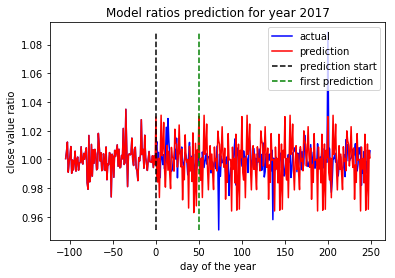

close mape 2017 =  8.193568824105121
close mse 2017 =  261.81996087564


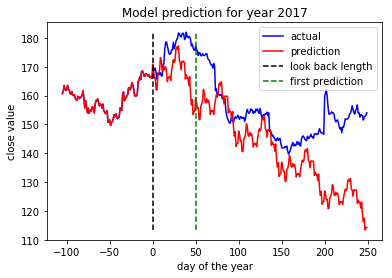

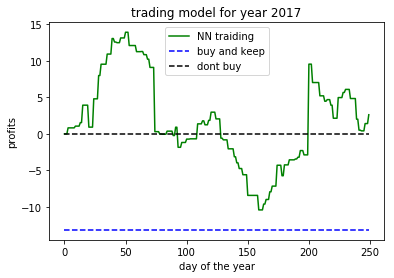

In [36]:
#plot ratios
plt.plot(range(-len(init_ratios),len(y_predict_ratios)),np.concatenate((init_ratios,test_ratios[:len(y_predict_ratios)]),axis=None),'b-',label='actual')
plt.plot(range(-len(init_ratios),len(y_predict_ratios)),np.concatenate((init_ratios,y_predict_ratios),axis=None),'r-',label='prediction')
plt.plot(np.array([0, 0]),np.array([min(np.array([min(test_ratios),min(y_predict_ratios)])), max(np.array([max(test_ratios),max(y_predict_ratios)]))]),'--',color='black',label='prediction start')
plt.plot(np.array([chunk_size_y, chunk_size_y]),np.array([min(np.array([min(test_ratios),min(y_predict_ratios)])), max(np.array([max(test_ratios),max(y_predict_ratios)]))]),'--',color='green',label='first prediction')
plt.title('Model ratios prediction for year 2017')
plt.ylabel('close value ratio')
plt.xlabel('day of the year')
plt.legend()
mse = np.mean((y_predict_ratios - test_ratios[:len(y_predict_ratios)])**2)
mape = np.mean(np.abs((y_predict_ratios-test_ratios[:len(y_predict_ratios)])/test_ratios[:len(y_predict_ratios)]*100))
print('ratios mape 2017 = ',mape)
print('ratios mse 2017 = ', mse)
if  save:
    if d == 1:
        plt.savefig('IBM_ratios_2017.png',bbox_inches='tight')
        np.savetxt('IBM_ratios_2017', y_predict_ratios)
    elif d==2 :
        plt.savefig('DOW_ratios_2017.png',bbox_inches='tight')
        np.savetxt('DOW_ratios_2017', y_predict_ratios)
    elif d == 3:
        plt.savefig('XOM_ratios_2017.png',bbox_inches='tight')
        np.savetxt('XOM_ratios_2017', y_predict_ratios)
plt.show()

#transform to data and plot
y_predict = np.zeros((len(y_predict_ratios)))
y_predict[0]=anchor*y_predict_ratios[0]
for i in range(len(y_predict_ratios)-1):
    y_predict[i+1]=y_predict[i]*y_predict_ratios[i+1]

#plot data
plt.plot(range(-len(init_seq),len(y_predict)),np.concatenate((init_seq,test_data[:len(y_predict)]),axis=None),'b-',label='actual')
plt.plot(range(-len(init_seq),len(y_predict)),np.concatenate((init_seq,y_predict),axis=None),'r-',label='prediction')
plt.plot(np.array([0,0]),np.array([min(np.array([min(test_data),min(y_predict),min(init_seq)])), max(np.array([max(test_data),max(y_predict),max(init_seq)]))]),'--',color='black',label='look back length')
plt.plot(np.array([chunk_size_y, chunk_size_y]),np.array([min(np.array([min(test_data),min(y_predict),min(init_seq)])), max(np.array([max(test_data),max(y_predict),max(init_seq)]))]),'--',color='green',label='first prediction')
plt.title('Model prediction for year 2017')
plt.ylabel('close value')
plt.xlabel('day of the year')
plt.legend()
mse = np.mean((y_predict- test_data[:len(y_predict)])**2)
mape = np.mean(np.abs((y_predict-test_data[:len(y_predict)])/test_data[:len(y_predict_ratios)]*100))
print('close mape 2017 = ',mape)
print('close mse 2017 = ', mse)
if  save:
    if d == 1 :
        plt.savefig('IBM_close_2017.png',bbox_inches='tight')
        np.savetxt('IBM_close_2017', y_predict)
    elif d==2 :
        plt.savefig('DOW_close_2017.png',bbox_inches='tight')
        np.savetxt('DOW_close_2017', y_predict)
    elif d == 3 :
        plt.savefig('XOM_close_2017.png',bbox_inches='tight')
        np.savetxt('XOM_close_2017', y_predict)
plt.show()

#trading
profits = traiding_model(y_predict, test_data[:len(y_predict)])
plt.plot(range(len(y_predict)),profits,'g-',label='NN traiding')
plt.plot([0,len(y_predict)-1],[test_data[len(y_predict)-1]-test_data[0], test_data[len(y_predict)-1]-test_data[0]],'--',color='blue', label='buy and keep')
plt.plot([0,len(y_predict)-1],[0,0],'--',color='black', label='don''t buy')
plt.title('trading model for year 2017')
plt.ylabel('profits')
plt.xlabel('day of the year')
plt.legend()
if save:
    if d == 1 :
        plt.savefig('IBM_trading_2017.png',bbox_inches='tight')
        np.savetxt('IBM_trading_2017', profits)
    elif d==2 :
        plt.savefig('DOW_trading_2017.png',bbox_inches='tight')
        np.savetxt('DOW_trading_2017', profits)
    elif d == 3 :
        plt.savefig('XOM_trading_2017.png',bbox_inches='tight')
        np.savetxt('XOM_trading_2017', profits)
plt.show()
